# alphalens_Demo

## 导入模块

In [11]:
import matplotlib
import pandas as pd
import numpy as np
import sunlandsdatasdk as sd
import feather
from datetime import datetime, timedelta
import sys

sys.path.append('../../public-Git/')
from alphalens_custom.tears import sd_get_Analysis_results
from alphalens_custom.utils import get_clean_factor_and_forward_returns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 数据准备, 行情 / 因子值

### 读入行情

In [2]:
prices = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')
prices = prices[prices['date'] >= '2018-01-01']
prices['close_adj'] = prices['close'] * prices['adj']
close = prices.pivot(index='date', columns='issue', values='close_adj')

In [3]:
close

issue,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,688787,688788,688789,688793,688798,688799,688800,688819,688981,689009
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1456.430446,4470.489815,90.786677,40.036045,327.212070,138.003576,193.399403,53.694565,59.044529,58.079758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1417.096193,4438.910802,96.719916,39.572665,327.212070,138.003576,192.958356,54.428098,59.583256,58.283786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,1408.591490,4547.377846,94.444153,39.758017,327.212070,138.003576,191.414689,56.041869,59.044529,58.317790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,1413.906930,4772.549938,94.200321,40.221397,327.212070,138.003576,188.547879,55.381690,60.768456,61.038154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,1377.761940,4941.429006,92.818608,40.499425,327.212070,138.003576,186.783688,55.161630,66.802204,60.800122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,1523.190616,1370.046554,59.454301,NaN,307.187688,54.919791,71.706538,83.934475,29.414519,39.299937,...,161.440177,45.826940,149.253144,47.959324,102.985587,45.169450,74.826402,29.742836,97.99,45.327052
2024-12-26,1515.523549,1364.595441,63.111777,NaN,307.585085,56.327990,69.241625,83.306089,29.845501,39.344045,...,164.702879,46.284209,146.918999,48.484633,104.068462,45.586103,86.152554,30.496364,96.73,45.407615
2024-12-27,1511.690016,1371.863592,58.844722,NaN,318.712194,58.813049,69.465708,84.562862,30.168737,39.829229,...,160.875207,46.527133,147.183242,46.766730,103.716879,45.586103,79.751433,30.141130,97.51,47.169942


### 读入因子文件

In [4]:
# factor = feather.read_dataframe('../data/N_connect_1_both/neutral_N_connect_num.feather')
# factor = factor.pivot(index='date', columns='issue', values='N_connect')
factor = feather.read_dataframe('../data/neutral_ret_jump.feather')
factor = factor.pivot(index='date', columns='issue', values='ret_jump')
factor = factor.reindex(index=close.index, columns=close.columns)

### 获取对标指数

In [18]:
# sd.auth('*', '*')
# benchmark = sd.get_index_bar('000905', start_date=20110101, end_date=20241231)
# benchmark['date'] = pd.to_datetime(benchmark['date'])
# benchmark = benchmark[['date', 'close']]
# feather.write_dataframe(benchmark, '../data/benchmark.feather')

In [21]:
benchmark = feather.read_dataframe('../data/benchmark.feather')
benchmark = benchmark.set_index('date')['close']

## 因子分析前置处理

### 上市日期限制标志

In [5]:
def filter_stock_byDate(close, filterdays_pre, filterdays_end):
    """
    按上市和退市时间标记可用时间为1，不可用为nan
    Parameters
    ----------
    close : 带有date和issue的时间序列.
    filterdays_pre : 上市filterdays_pre之后置标记
    filterdays_end : 退市filterdays_pre之前置标记

    Returns
    -------
    date,issue,filterFlag

    """
    close = close.astype('float64')
    close[close < 0.01] = np.nan
    filterFlag_pre = close.shift(filterdays_pre)
    filterFlag_pre.iloc[:filterdays_pre] = close.iloc[0]
    filterFlag_end = close.shift(-filterdays_end)
    filterFlag_end.iloc[-filterdays_end:] = close.iloc[-1]

    filterFlag = close*np.nan
    filterFlag[close.notna()] = 1
    filterFlag[filterFlag_pre.isna()] = np.nan
    filterFlag[filterFlag_end.isna()] = np.nan

    return filterFlag

In [6]:
filterFlag = filter_stock_byDate(close, 180, 0)
factor = factor * filterFlag

### 去除涨跌停股票

In [7]:
is_limit_buy = prices.pivot(index='date', columns='issue', values='is_limit_buy')
is_limit_sell = prices.pivot(index='date', columns='issue', values='is_limit_sell')
factor[is_limit_buy == 1] = np.nan
factor[is_limit_sell == 1] = np.nan

### 调整因子矩阵

In [8]:
factor = pd.DataFrame(factor.stack().rename('factor'))

In [9]:
factor

factor
date       issue           
2019-08-30 000001  0.005172
           000002 -0.032602
           000004  0.058249
           000006  0.081987
           000007 -0.009436
...                     ...
2024-06-28 688799  0.045917
           688800  0.003513
           688819 -0.039342
           688981  0.113162
           689009  0.045635

[233193 rows x 1 columns]

## 因子分析模块

### 对标指数超额收益模式

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!
FactorValues Quantiles Statistics


,min,max,mean,std,count,daily_count,count %
factor_quantile,,,,,,,
1,-0.796615,-0.004176,-0.094972,0.083377,23346,395.0,10.01
2,-0.136573,0.023436,-0.027439,0.024397,23316,395.0,9.99
3,-0.115247,0.043638,-0.007359,0.021919,23308,395.0,9.99
4,-0.101871,0.062022,0.007519,0.021707,23319,395.0,9.99
5,-0.088968,0.080615,0.021397,0.022361,23321,395.0,10.00
6,-0.073485,0.101636,0.035942,0.023481,23305,395.0,9.99
7,-0.056070,0.126297,0.052876,0.025251,23312,395.0,9.99
8,-0.033621,0.160778,0.074260,0.027595,23315,395.0,9.99
9,-0.003018,0.217513,0.105892,0.031986,23309,395.0,9.99


Turnover Analysis


,1D,20D,60D
Quantile 1 Mean Turnover,0.875,0.045,NaN
Quantile 2 Mean Turnover,0.889,0.046,NaN
Quantile 3 Mean Turnover,0.886,0.045,NaN
Quantile 4 Mean Turnover,0.892,0.046,NaN
Quantile 5 Mean Turnover,0.890,0.046,NaN
Quantile 6 Mean Turnover,0.899,0.046,NaN
Quantile 7 Mean Turnover,0.896,0.046,NaN
Quantile 8 Mean Turnover,0.891,0.046,NaN
Quantile 9 Mean Turnover,0.883,0.046,NaN
Quantile 10 Mean Turnover,0.813,0.045,NaN


,1D,20D,60D
Mean Factor Rank Autocorrelation,0.112,0.038,NaN




longshort AnalysisMode Returns Analysis 


,1D,20D,60D
Top Ret,44.77,-11.45,-9.89
Bottom Ret,-43.15,-0.13,-0.19
Top RetAE,19.53,-12.39,-9.89
Bottom RetAE,-70.33,-1.08,-0.19
Spread RetAE,35.50,-13.21,-9.70
Spread RetAE MDD,-9.19,-3.54,-2.35
Spread RetAE SPR,1.81,-1.22,-0.97




longshort AnalysisMode Returns Analysis By Year 


,Top Ret,Top RetAE,Bottom Ret,Bottom RetAE,Spread Ret,Spread RetAE,Spread RetAE SharpeRatio,Spread RetAE max_drawdown,RetAE Top SPR,RetAE Top MDD
date,,,,,,,,,,
2019,82.78,62.47,-18.69,-41.22,101.47,58.63,8.20,-0.41,11.27,-0.18
2020,240.71,215.04,-66.01,-93.88,306.71,253.16,9.11,-1.70,9.50,-1.06
2021,-78.36,-103.81,-44.87,-72.14,-33.49,-86.22,-3.88,-7.34,-6.70,-6.54
2022,-32.65,-58.83,-30.14,-57.47,-2.51,-56.02,-4.58,-3.91,-9.46,-3.02
2023,47.61,22.28,-63.93,-91.86,111.54,58.29,3.74,-2.77,1.80,-2.26
2024,16.68,-9.39,1.14,-26.54,15.54,-38.22,-4.06,-1.33,-1.03,-0.96




Information Analysis


,1D,20D,60D
IC Mean,0.008,-0.050,-0.062
IR,0.069,-0.587,-0.816
Good IC Ratio,0.915,0.915,0.915
IC Mean SD_20D,0.601,-0.364,-0.464
IR SD_20D,1.365,-0.985,-1.479
IC Mean SD_60D,NaN,NaN,NaN
IR SD_60D,NaN,NaN,NaN


<Figure size 640x480 with 0 Axes>

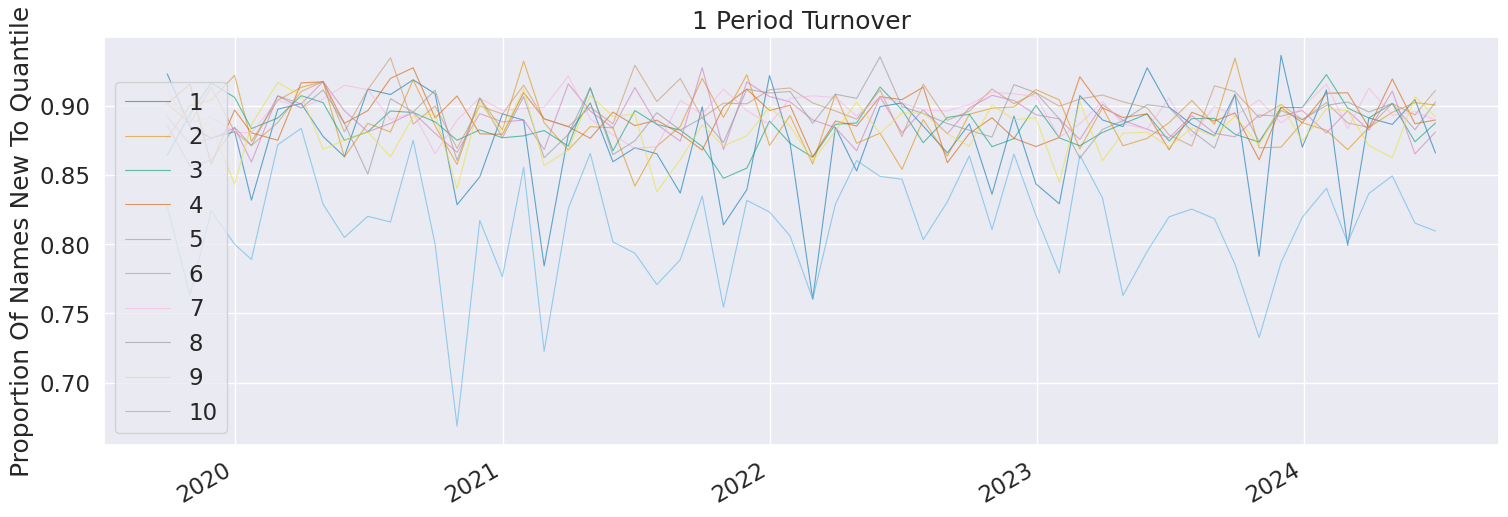

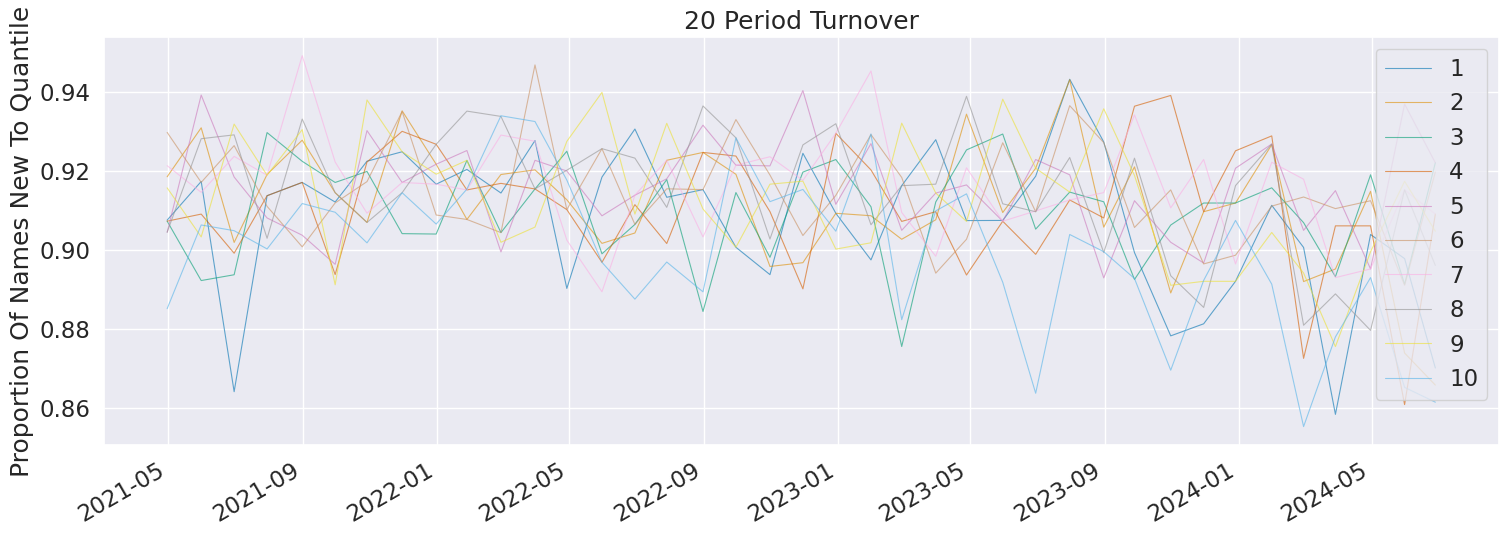

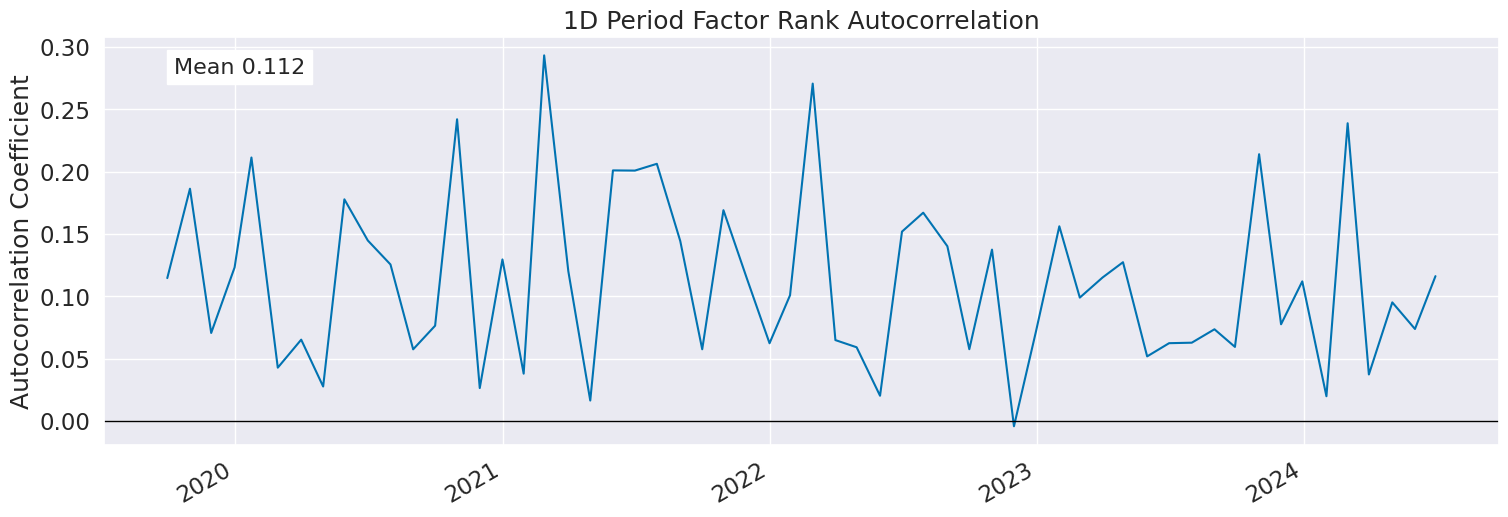

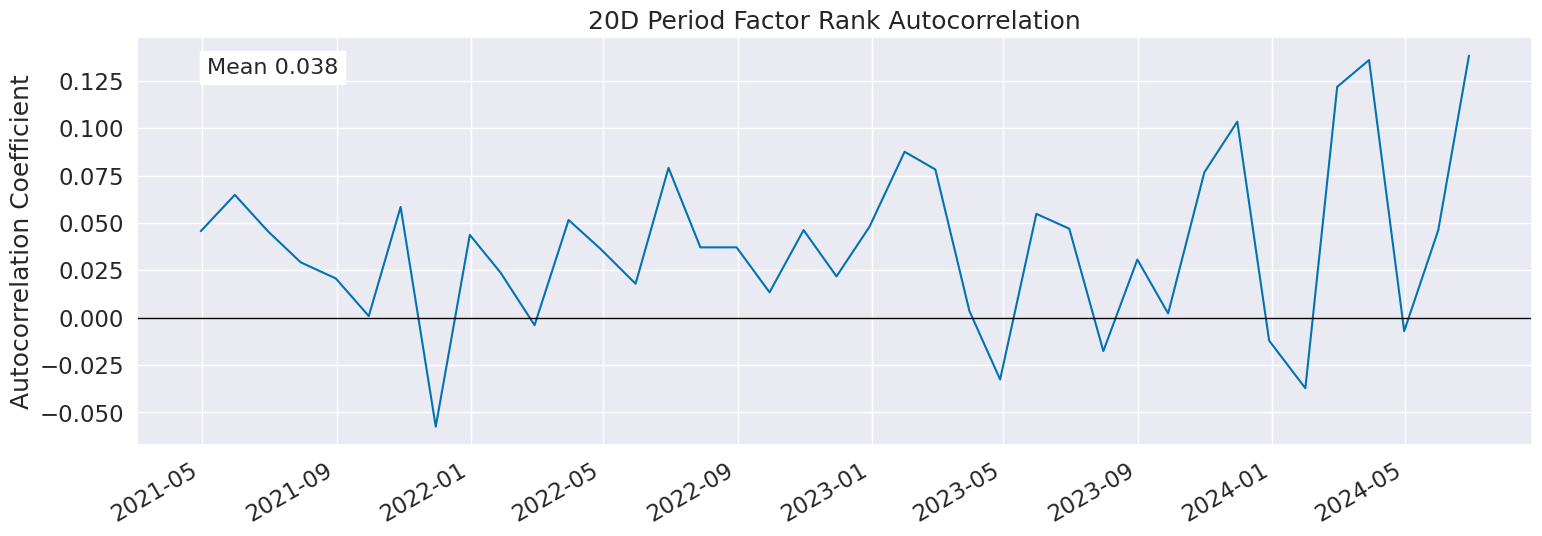

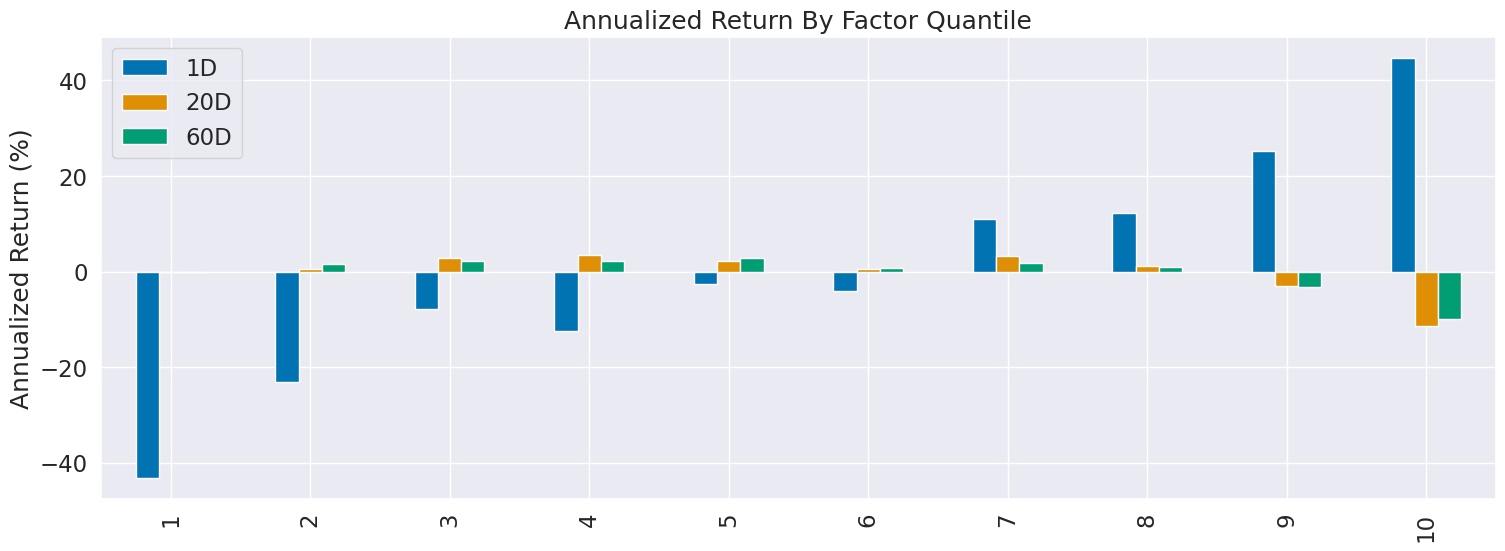

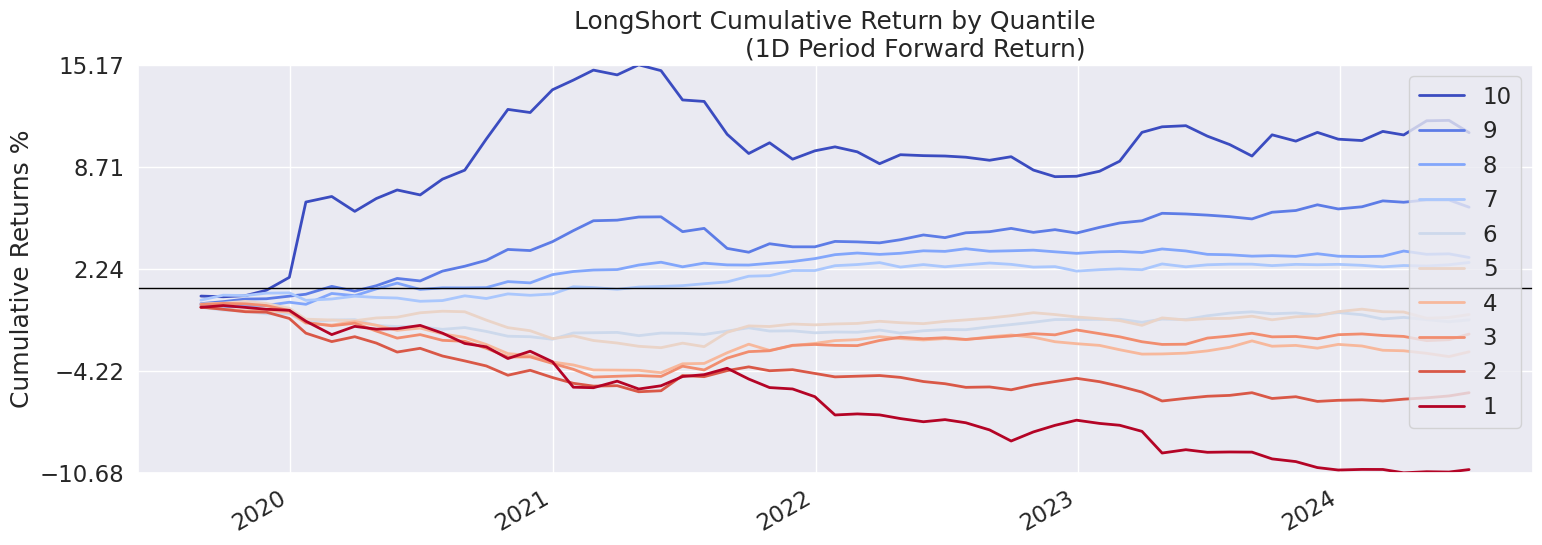

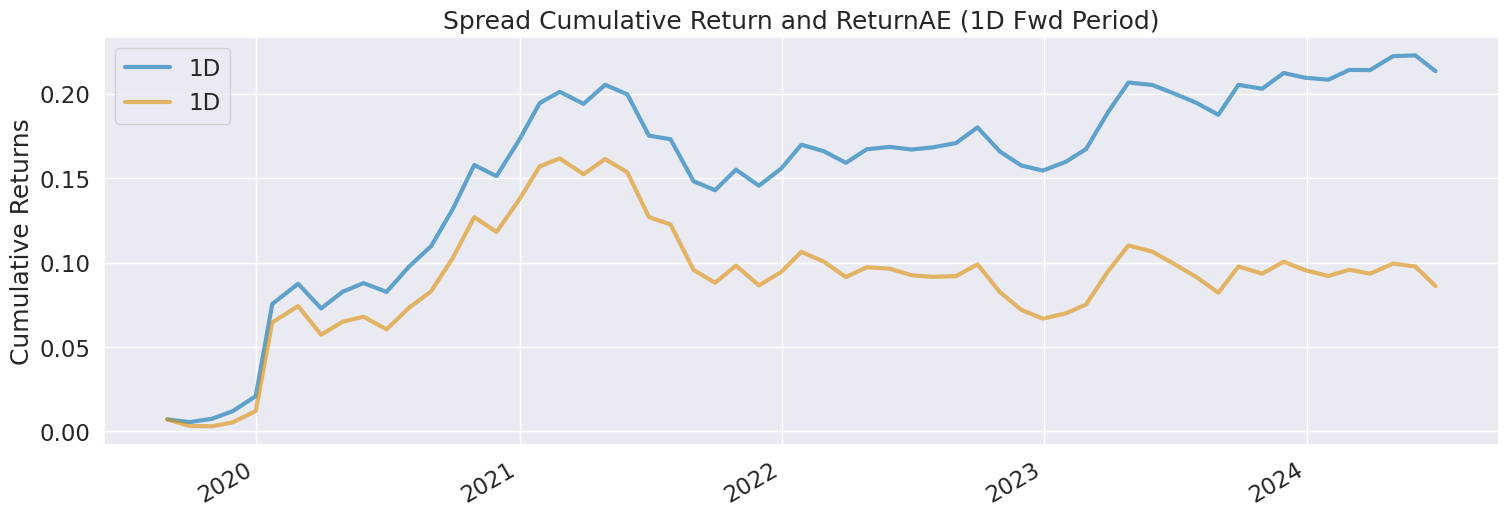

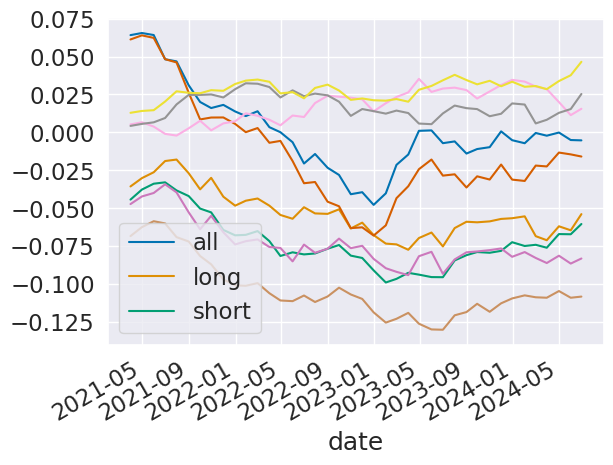

In [22]:
factor_data = get_clean_factor_and_forward_returns(
    factor=factor, prices=close,
    quantiles=10,
    benchmark=benchmark,
    bins=None,
    periods=(1, 20, 60),
    filter_zscore=20000,
    max_loss=0.15,
    zero_aware=False,
    cumulative_returns=True
)
results = sd_get_Analysis_results(factor_data, ana_mode='longshort', plot=True)